In [106]:
from operator import le
import os
from textwrap import wrap
import numpy as np
import math

from scipy.sparse.linalg.dsolve.linsolve import use_solver
from preprocessing import *
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
from ekf_functions import *
import LAMBDA


In [107]:
np.random.seed(0)
cwd = os.getcwd()
dir_path = cwd[:-3]

###################### SETUP ######################
#- params -------------------------------------------
# measurement date in YYYY-MM-DD
date = np.datetime64("2021-08-26")

# trajectory and  data collection params
truth_frequency = 4
dt = 1 / truth_frequency
obs_freq = 2
leap_seconds = 18
x0 = np.array([-2.7011e+06,-4.292e+06, 3.8554e+06])

# other
ksnr = 200
phase_ratio = 300 	    # sigma phase = sigma code / phase_ratio
f = 1575.42 * 10 ** 6
c = 299792458
lda = c / f


#- observation and grouth truth files ------------------
name_obs1 = dir_path + 'data/20210826_data/leader2.21O'
name_obs2 = dir_path + 'data/20210826_data/follower.21O' 
name_eph =  dir_path + 'data/20210826_data/leader2.21N'

ground_truth = np.loadtxt(dir_path + 'data/20210826_data/Ground_Truth_Static.csv', delimiter = ",")  # ENU
uwb_data = np.loadtxt(dir_path + 'data/20210826_data/UWB_Baseline_Static.csv', delimiter = ",")    

#- preprocess-------------------------------------------
traj1, traj2, eph = loadTrajectories(name_obs1, name_obs2, name_eph)
print('trajectories loaded')

t_gps, svs, code1, code2, carrier1, carrier2, cnos, ts = constructMeasurements(traj1, traj2, date, sort_cn0 = False)
cnos = np.array(cnos)
print('measurements constructed')

trajectories loaded
measurements constructed


<ipython-input-107-418dd3edb3ec>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cnos = np.array(cnos)


In [108]:
import numpy as np

def init_covariances(k, nState, nMeas):

    # State Covariance
    sig_pos = 2
    sig_vel = 5
    sig_intamb = 10
    P = np.zeros((nState, nState))
    P[0:2, 0:2] = sig_pos ** 2 * np.eye(2)
    P[2:4, 2:4] = sig_vel ** 2 * np.eye(2)
    P[4:, 4:] = sig_intamb ** 2 * np.eye(k)
    
    # Dynamics Process Noise
    sig_east = 1 # [m]
    sig_north = 1 # [m]
    sig_vel = 0.1  # [m / s]
    sig_intamb = 1   
    Q = np.zeros((nState, nState))
    Q[0, 0] = sig_east ** 2
    Q[1, 1] = sig_north ** 2
    Q[2:4, 2:4] = sig_vel ** 2 * np.eye(2)
    Q[4:, 4:] = sig_intamb ** 2 * np.eye(k)

    # Measurement Noise
    sig_uwb = 0.1
    sig_gps_phi = 1
    sig_gps_rho = 15
    R = np.zeros((nMeas, nMeas))
    R[0:k, 0:k] = sig_gps_phi ** 2 * np.eye(k)
    R[k:2*k, k:2*k] = sig_gps_rho ** 2 * np.eye(k)
    R[2*k:, 2*k:] = sig_uwb ** 2 * np.eye(nMeas - 2*k)

    return P, Q, R, sig_uwb, sig_gps_rho, sig_gps_phi

entering loop
code done
Sig UWB 0.1
Sig Phi 1
Sig Rho 15
Err E. Avg: Base -2.9088738262329676
Err N. Avg: Base 2.5985928784875028
Err E. Avg: Lambda -2.667462034237995
Err N. Avg: Lambda 2.778781775089465
Err E. Avg: Round -2.667462034237995
Err N. Avg: Round 2.778781775089465


Text(0.5, 0, 'time')

<Figure size 432x288 with 0 Axes>

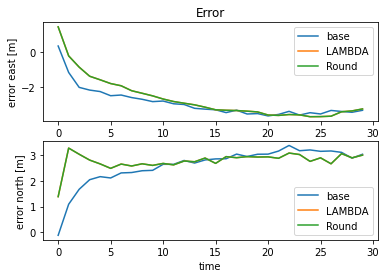

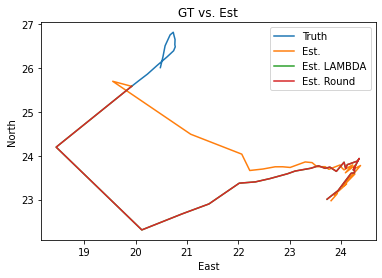

<Figure size 432x288 with 0 Axes>

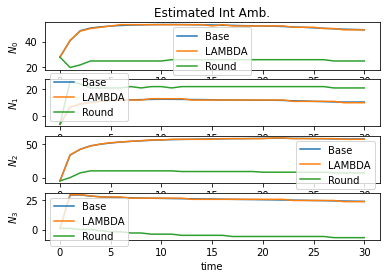

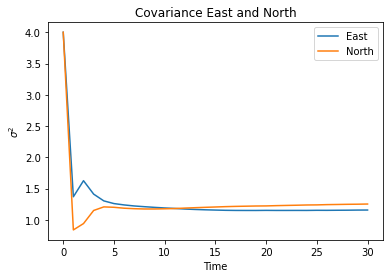

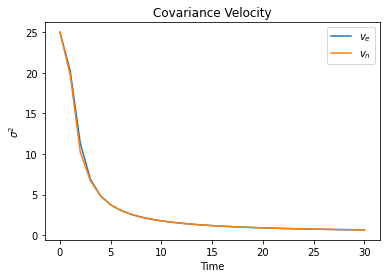

<Figure size 432x288 with 0 Axes>

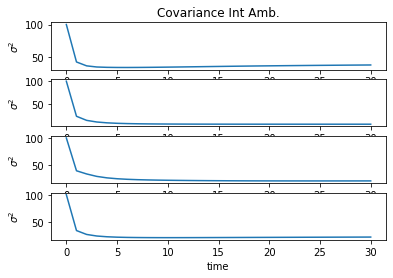

In [109]:
seg_start_ind = 82
seg_end_ind = 111

# seg_start_ind = 1
# seg_end_ind = 14

# seg_start_ind = 123
# seg_end_ind = 144

################### INITIALIZE FILTER ####################
# filtering params
common_svs = ['G08', 'G10', 'G23', 'G27', 'G32']           # for segment 82 - 111
# common_svs = ['G08', 'G10', 'G21', 'G23', 'G27', 'G32']   # for segment 1 - 14
K = len(common_svs) - 1     # number of unique DD measurements
ref_ind = -1
w = 1                       # num UWB range
nState = 4 + K              # state vector size
nMeas = 2 * K + w           # measurement vector size

x_pre = np.zeros((nState, 1))
x_pre[0] = 19.92
x_pre[1] = 25.58
x_pre[2] = 1
x_pre[3] = 1
# x_pre[4] = -19
x_pre[5] = -6
x_pre[6] = -5
x_pre[7] = 1
x_pre[4] = 28
# x_pre[5] = 9
# x_pre[6] = 43
# x_pre[7] = 22

P_pre, Q, R, sig_uwb, sig_gps_rho,  sig_gps_phi = init_covariances(K, nState, nMeas)

x_pre_lambda = copy(x_pre)
P_pre_lambda = copy(P_pre)

x_pre_round = copy(x_pre)
P_pre_round = copy(P_pre)

################### MAIN LOOP #############################
truth = []

est = []
est_lambda = []
est_round = []

error = []
error_lambda = []
error_round = []

covars = []
covars_lambda = []
covars_round = []


est.append(np.ndarray.flatten(x_pre))
covars.append(P_pre)

est_lambda.append(np.ndarray.flatten(x_pre_lambda))
covars_lambda.append(P_pre_lambda)

est_round.append(np.ndarray.flatten(x_pre_round))
covars_round.append(P_pre_round)

#---- match the start time between ground truth and obs. files -------
obs_start_ind = get_obs_startInd(ts, date, ground_truth)
if truth_frequency > obs_freq:
    gt_inds = np.arange(0, len(ground_truth), truth_frequency / obs_freq)
    obs_inds = np.arange(obs_start_ind, obs_start_ind + math.ceil(len(ground_truth) / (truth_frequency / obs_freq)), 1)
else:
    gt_inds = np.arange(0, len(ground_truth), 1)
    obs_inds = np.arange(obs_start_ind, obs_start_ind + (len(ground_truth)-1) * (obs_freq / truth_frequency), obs_freq / truth_frequency)

gt_inds = gt_inds.astype(int)
obs_inds = obs_inds.astype(int)
starting = 1

sigma_code = [1 for i in range(8)]
sigma_phase= [0.01 for i in range(8)]
init_n = None
# -------------------------------------------------------------------

print('entering loop')
for i in range(seg_start_ind, seg_end_ind + 1):
# for i in range(seg_start_ind, seg_start_ind + 1):
    
    # get appropriate indices
    gt_ind = gt_inds[i]
    obs_ind = obs_inds[i]
    
    # GROUND TRUTH
    truth_term = ground_truth[gt_ind, 1:]
    truth.append(truth_term[0:2])

    # MEASUREMENTS
    # gps
    svs_obs = svs[obs_ind]
    select_inds = np.where(np.isin(svs_obs, common_svs))
    select_inds = select_inds[0].tolist()

    select_code1 = [code1[obs_ind][i] for i in select_inds]
    select_code2 = [code2[obs_ind][i] for i in select_inds]
    select_carrier1 = [carrier1[obs_ind][i] for i in select_inds]
    select_carrier2 = [carrier2[obs_ind][i] for i in select_inds]

    sigma_code, sigma_phase = sigmaFromCN0(cnos[obs_ind], ksnr, phase_ratio)
    # psi, G, A, sigma = prepareData(t_gps[obs_ind], svs[obs_ind], code1[obs_ind], code2[obs_ind], carrier1[obs_ind], carrier2[obs_ind], eph, plane=False, ref= -1, x0=x0, f=1575.42*10**6, phase_error=0.025)
    psi, G, A, sigma =\
         prepareData(t_gps[obs_ind], common_svs, np.array(select_code1), np.array(select_code2), np.array(select_carrier1), np.array(select_carrier2), eph, plane=False, ref= -1, x0=x0, f=1575.42*10**6, phase_error=0.025)
    k = psi.shape[0] // 2               # number of satellites visibe this time step
    if k != K:
        print('Error: Satellite number incorrect')
    H = np.zeros((2 * k, G.shape[1]))
    H[:k] = G
    H[k:] = G
    psi -= truth_term[2] * H[:, 2]
    H = H[:, :2]

    # ### uncomment code below to initialize int. ambiguities in filter states
    # freq = 1575.42*10**6
    # c = 299792458
    # lda = c/freq
    # init_n = (psi[0: A.shape[0]//2] - psi[A.shape[0]//2:]) / lda
    # print(init_n)
    # ######################################################################
   

    # uwb
    uwb_range = uwb_meas(truth_term[0:2]) + np.random.normal(0, sig_uwb, 1)
    y = np.reshape(np.append(psi, uwb_range), (2 * k + w, 1))

    # EKF
    x_next, P_next = ekf_gnss_uwb(x_pre, P_pre, y, dt, w, H, A, Q, R)
    x_next_lambda, P_next_lambda = ekf_gnss_uwb(x_pre_lambda, P_pre_lambda, y, dt, w, H, A, Q, R)
    x_next_round, P_next_round = ekf_gnss_uwb(x_pre_round, P_pre_round, y, dt, w, H, A, Q, R)


    # LAMBDA
    C = A
    Qi = np.linalg.inv(sigma)
    Qhat = np.linalg.inv(np.dot(C.T, np.dot(Qi, C)))
    Qahat = (Qhat + Qhat.T) /2
    afixed, sqnorm, Ps, Qzhat, Z, nfixed, mu = LAMBDA.main(x_next[4:], Qahat, 1)
    if afixed.ndim > 1:
        afixed = afixed[:,0]

    # fix position 
    a = psi[:k]
    b =  lda * afixed
    fixed_pos =  a - b
    fixed_pos = np.dot(np.linalg.pinv(H[:k]), fixed_pos)
    fixed_pos = np.reshape(fixed_pos, (2, 1))

    around = []
    for jj in range(K):
        around.append(round(x_next_round[jj][0]))
    around = np.array(around)
    b_r = lda * around
    round_pos = a - b
    round_pos = np.dot(np.linalg.pinv(H[:k]), round_pos)
    round_pos = np.reshape(round_pos, (2, 1))

    # update estimate
    err = truth_term[0:2] - np.ndarray.flatten(x_next[0:2])

    x_next_lambda[0:2] = fixed_pos
    x_next_lambda[4:] = np.reshape(afixed, (K, 1))
    err_lambda = truth_term[0:2] - np.ndarray.flatten(x_next_lambda[0:2])

    x_next_round[0:2] = round_pos
    x_next_round[4:] = np.reshape(around, (K, 1))
    err_round = truth_term[0:2] - np.ndarray.flatten(x_next_round[0:2])

    # store
    est.append(np.ndarray.flatten(x_next))
    covars.append(P_next)
    error.append(err)

    est_lambda.append(np.ndarray.flatten(x_next_lambda))
    covars_lambda.append(P_next_lambda)
    error_lambda.append(err_lambda)

    est_round.append(np.ndarray.flatten(x_next_round))
    covars_round.append(P_next_round)
    error_round.append(err_round)

    x_pre = copy(x_next)
    P_pre = copy(P_next)

    x_pre_lambda = copy(x_next_lambda)
    P_pre_lambda = copy(P_next_lambda)

    x_pre_round = copy(x_next_round)
    P_pre_round = copy(P_next_round)

print ('code done')


################### PLOTTING ####################
truth = np.array(truth)

est = np.array(est)
error = np.array(error)
covars = np.array(covars)

est_lambda = np.array(est_lambda)
error_lambda = np.array(error_lambda)
covars_lambda = np.array(covars_lambda)

est_round = np.array(est_round)
error_round = np.array(error_round)
covars_round = np.array(covars_round)

# error plot
plt.figure()
fig_err, ax_err = plt.subplots(2, 1)
for i in range(2):
    ax_err[i].plot(error[:, i])
    ax_err[i].plot(error_lambda[:, i])
    ax_err[i].plot(error_round[:, i])
    ax_err[i].legend(['base', 'LAMBDA', 'Round'])
ax_err[0].set_title('Error')
ax_err[1].set_xlabel('time')
ax_err[0].set_ylabel('error east [m]')
ax_err[1].set_ylabel('error north [m]')

print('Sig UWB', sig_uwb)
print('Sig Phi', sig_gps_phi)
print('Sig Rho', sig_gps_rho)


print('Err E. Avg: Base', np.mean(error[:, 0]))
print('Err N. Avg: Base', np.mean(error[:, 1]))

print('Err E. Avg: Lambda', np.mean(error_lambda[:, 0]))
print('Err N. Avg: Lambda', np.mean(error_lambda[:, 1]))

print('Err E. Avg: Round', np.mean(error_round[:, 0]))
print('Err N. Avg: Round', np.mean(error_round[:, 1]))


# position coord plots
plt.figure()
plt.title('GT vs. Est')
plt.plot(truth[:, 0], truth[:, 1])
plt.plot(est[:, 0], est[:, 1])
plt.plot(est_lambda[:, 0], est_lambda[:, 1])
plt.plot(est_round[:, 0], est_round[:, 1])
plt.xlabel('East')
plt.ylabel('North')
plt.legend(['Truth', 'Est.', 'Est. LAMBDA', 'Est. Round'])


# interger ambiguities
plt.figure()
fig_ints, ax_ints = plt.subplots(K, 1)
for i in range(K):
    ax_ints[i].plot(est[:, i + 4])
    ax_ints[i].plot(est_lambda[:, i + 4])
    ax_ints[i].plot(est_round[:, i + 4])
    ax_ints[i].set_ylabel('$N_{int}$'.format(int=i))
    ax_ints[i].legend(['Base', 'LAMBDA', 'Round'])
ax_ints[0].set_title('Estimated Int Amb.')
ax_ints[-1].set_xlabel('time')


# Position covariances
plt.figure()
plt.title('Covariance East and North')
plt.plot(covars[:, 0, 0])
plt.plot(covars[:, 1, 1])
plt.xlabel('Time')
plt.ylabel('$\sigma^{2}$')
plt.legend(['East', 'North'])

# Velocity covariances
plt.figure()
plt.title('Covariance Velocity')
plt.plot(covars[:,2,2])
plt.plot(covars[:,3,3])
plt.xlabel('Time')
plt.ylabel('$\sigma^{2}$')
plt.legend(['$v_{e}$', '$v_{n}$'])

# integer ambiguities covariances
plt.figure()
fig_covSat, ax_covSat = plt.subplots(K, 1)
for i in range(K):
    ax_covSat[i].plot(covars[:, i + 4, i + 4])
    ax_covSat[i].set_ylabel('$\sigma^{2}$')
ax_covSat[0].set_title('Covariance Int Amb.')
ax_covSat[-1].set_xlabel('time')

